In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
daily_data = pd.read_csv('05-10-2022.csv')
confirm_time_series = pd.read_csv('time_series_covid19_confirmed_global.csv')
death_time_series = pd.read_csv('time_series_covid19_deaths_global.csv')
vaccine_time_series = pd.read_csv('time_series_covid19_vaccine_doses_admin_global.csv')

daily_data.loc[:,'Incident'] = (daily_data['Incident_Rate']/100000)*daily_data['Confirmed']

data = vaccine_time_series.iloc[:,12:].diff(axis=1)
data[data<0] = 0
data = data.sum()
index = map(lambda i:(lambda y,m,d:f'{int(m)}/{int(d)}/{y[2:]}')(*i.split("-")),data.index)
data.index = list(index)
data = pd.DataFrame({
    'Confirmed':confirm_time_series.iloc[:,4:].sum().diff(),
    'Deaths':death_time_series.iloc[:,4:].sum().diff(),
    'Vaccinated':data
})
data.index = list(map(lambda i:(lambda m,d,y:f'{y}/{int(m):02d}/{int(d):02d}')(*i.split('/')),data.index))
combined_time_series = data.sort_index()

daily_data['Vaccinated'] = 0

for i,row in vaccine_time_series.iterrows():
    if type(row[row.last_valid_index()])!=str:
        row['Vaccinated'] = row[row.last_valid_index()]
        if str(row['Province_State']) in ['nan','Unassigned']:
            loc = (daily_data['Country_Region']==row['Country_Region'])|(daily_data['Combined_Key']==row['Combined_Key'])
        else:
            loc = (daily_data['Country_Region']==row['Country_Region'])&(daily_data['Province_State']==row['Province_State'])|(daily_data['Combined_Key']==row['Combined_Key'])
        if any(loc):
            daily_data.loc[loc,'Vaccinated'] = row['Vaccinated']/sum(loc)
        else:
            if str(row['Lat']) in ['nan','Unassigned']:
                # if any(row['Country_Region']==daily_data['Country_Region']):
                loc = daily_data[daily_data['Country_Region']==row['Country_Region']]
                if len(loc)==1:
                    daily_data.loc[loc.index,'Vaccinated'] += row['Vaccinated']
                else:
                    # not found
                    pass
            else:
                daily_data = daily_data.append(row[['Country_Region','Province_State','Combined_Key','Lat','Long_','Vaccinated']],ignore_index=True)

%matplotlib inline

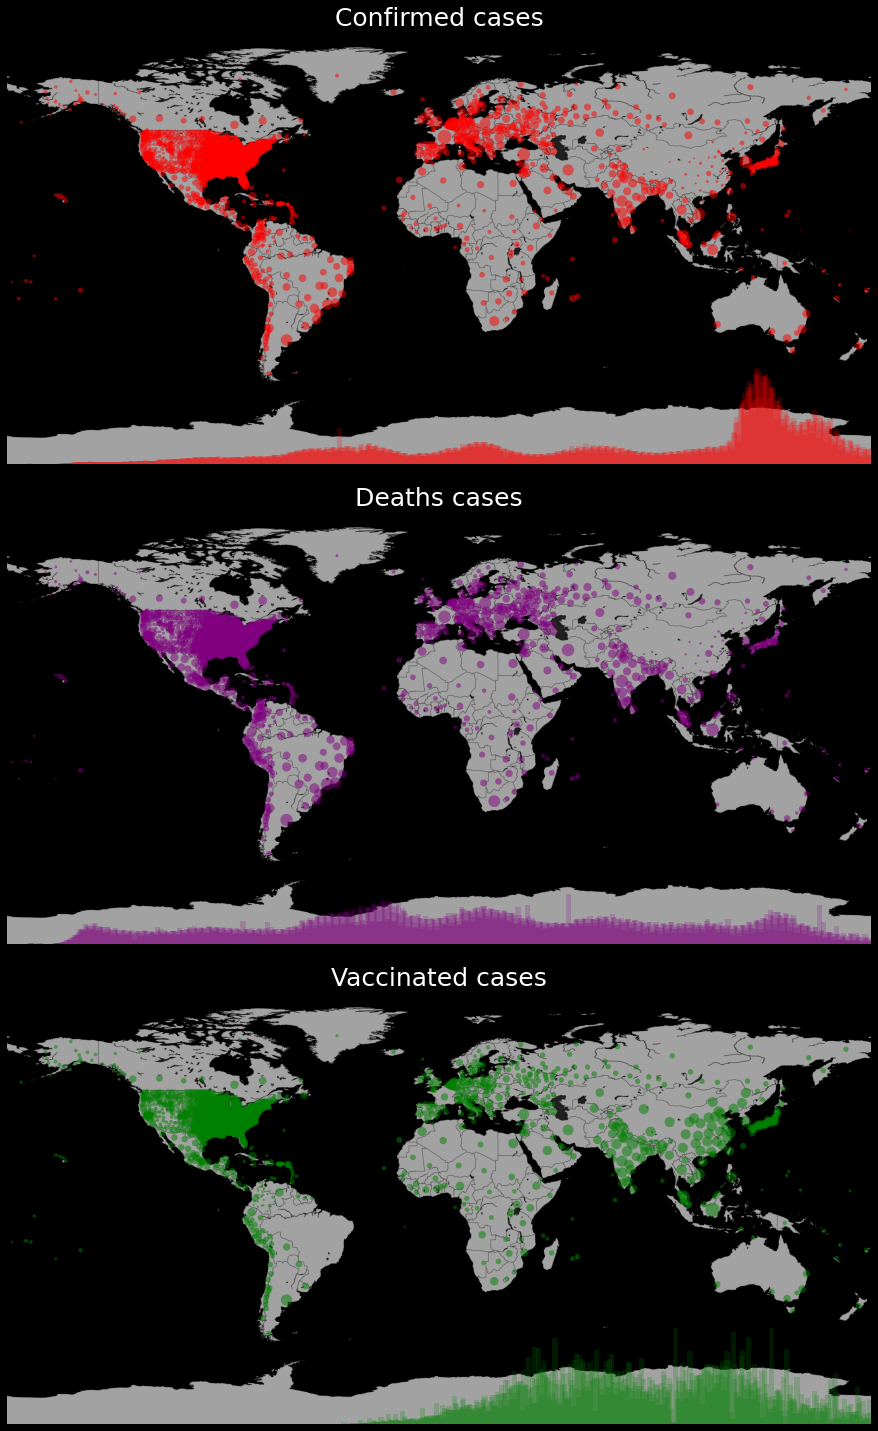

In [46]:
img = plt.imread("world_map.png", 0)
fig = plt.figure(figsize=(15,20),facecolor='black')

for i,k,c,m in zip(range(3),('Confirmed', 'Deaths', 'Vaccinated'),('red','purple','green'),(4e6,4e4,1e8)):
    plt.axes([0, (2-i)/3, 1, 1/3-1/30],facecolor='black')
    plt.title(f'{k} cases', fontsize=25, color='white')
    plt.imshow(img, extent=[-180, 180, -90, 90])
    plt.axis('off')
    plt.scatter(daily_data['Long_'], daily_data['Lat'], s=100*np.cbrt(daily_data[k]/m), color=c,linewidths=.1,alpha=0.5)

    plt.axes([1/10, (2-i)/3, 4/5, 1/15],facecolor='black')
    plt.bar(combined_time_series.index, combined_time_series[k], color=c,alpha=0.2,width=5)
    plt.xticks([0,420,len(data[k])-1],['2020/1/22','2021/3/17','2022/5/9'],rotation=0)
    plt.axis('off')
    plt.xlim(0,len(data[k])-1)
    plt.ylim(top=m)
# plt.xticks([0,420,len(data[k])-1],['2020/1/22',' 2021/3/17','2022/5/9'],rotation=0,color='white')
plt.show()
# plt.savefig('map.png',dpi=500,bbox_inches='tight',pad_inches=0) #保存图片